## Práctica 2 Ernesto Pablo Vallejo Luengo

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import confusion_matrix
import pandas as pd

Primero se dividen los datos en train set y test set. A continuación se divide de nuevo el train set para obtener el validation set. También se divide el valor de los píxeles entre 255 para que los inputs de la red neuronal reciban números entre 0 y 1.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Se construye la función que crea y compila el modelo. La función de activación de las capas internas es 'relu' y la de la capa de output es 'softmax' tal y como se ha visto en el libro.

In [5]:
# Función que crea y compila el modelo
def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
    return model

## 2 capas ocultas

Tanto para el modelo de 2 capas como para el resto se ha elegido que las capas internas tengan 300 neuronas. Se ha elegido este número porque, como se explica en el libro, es mejor tener neuronas de sobra y evitar el overfitting usando early stopping que gastar tiempo en buscar al número óptimo para cada capa.

Para calcular el learning rate óptimo se va a hacer un bucle en el que se entrena el modelo durante solo un epoch y se almacena el valor de la función de pérdida. En cada bucle se aumenta el learning rate hasta llegar a 1. 

In [5]:
my_learning_rate = 1e-3
rates = []
losses = []
while my_learning_rate <= 1:
    model = build_model(n_hidden=2, n_neurons=300, learning_rate=my_learning_rate)
    history = model.fit(X_train, y_train, epochs=1,
              validation_data=(X_valid, y_valid))
    rates.append(my_learning_rate)
    losses.append(history.history['loss'][0])
    my_learning_rate = my_learning_rate*1.05    

1719/1719 [==============================] - 2s 1ms/step - loss: 0.5522 - accuracy: 0.8559 - val_loss: 0.2799 - val_accuracy: 0.9238


1719/1719 [==============================] - 2s 1ms/step - loss: 0.2301 - accuracy: 0.9288 - val_loss: 0.1686 - val_accuracy: 0.9470


1719/1719 [==============================] - 2s 1ms/step - loss: 1.3451 - accuracy: 0.5334 - val_loss: 0.8039 - val_accuracy: 0.7048


Representando la función de pérdida en función del learning rate se observa que esta va descendiendo hasta alcanzar un mínimo y a coninuación vuelve a incrementarse hasta que diverge. Para entrenar el modelo se usará un learning rate de 0.2.

Text(0, 0.5, 'Loss')

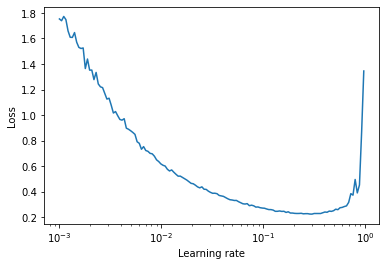

In [6]:
plt.plot(rates, losses)
plt.gca().set_xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Se crea la ruta para almacenar los logs de tensorboard

In [8]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = os.path.join('two_layer_model',get_run_logdir())

Se crean tres callbacks para el modelo. Uno para almacenar los logs de tensorboard, otro para que haga checkpoints del modelo y guarde el mejor y un último para implementar el early stopping. Como se ha visto que en general el modelo tarda pocas epochs en entrenarse se ha puesto una paciencia de 20 en el early stopping, que no supone un gran aumento en el tiempo de calculo.

In [23]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint("two_layer_model.h5",
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

Con todo listo se empieza a entrenar el modelo.

In [24]:
two_layer_model = build_model(n_hidden=2, n_neurons=300, learning_rate=0.2)
two_layer_history = two_layer_model.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2312 - accuracy: 0.9287 - val_loss: 0.1074 - val_accuracy: 0.9674
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0917 - accuracy: 0.9718 - val_loss: 0.0945 - val_accuracy: 0.9728
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0615 - accuracy: 0.9802 - val_loss: 0.0817 - val_accuracy: 0.9724
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0434 - accuracy: 0.9858 - val_loss: 0.0788 - val_accuracy: 0.9774
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0325 - accuracy: 0.9890 - val_loss: 0.0694 - val_accuracy: 0.9802
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0733 - val_accuracy: 0.9818
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0752 - val_ac

In [25]:
loss_2l, accuracy_2l = two_layer_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 628us/step - loss: 0.0615 - accuracy: 0.9831


Se consigue una exactitud de alrededor del 98% para el test set. Debido a la aleatoriedad en el proceso de entrenamiento esta precisión puede variar ligeramente.

In [9]:
def plot_accuracy_loss(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()

Representando los valores de accuracy y loss en función de las epoch se ve que después de las primeras iteraciones los valores no varían mucho. 

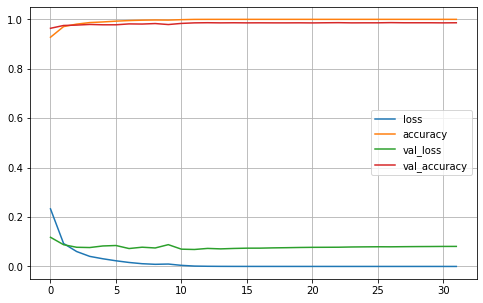

In [12]:
plot_accuracy_loss(two_layer_history)

In [10]:
def round_predictions(y):
    return [np.argmax(i) for i in y]

In [14]:
y_pred = two_layer_model.predict(X_test)

In [11]:
def plot_conf_mx(pred):
    conf_mx= confusion_matrix(y_test, round_predictions(pred))
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.show()

Representando la matriz de confusión se puede ver en qué números se suele equivocar el modelo. Se ha modificado la matriz para que la diagonal principal sean todo ceros y que así los errores destaquen más. 

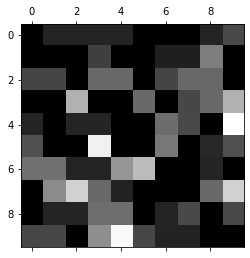

In [16]:
plot_conf_mx(y_pred)

## 3 capas ocultas

Se repite el mismo proceso para elefir el learning rate para el modelo de 3 capas ocultas.

In [17]:
my_learning_rate = 1e-3
rates = []
losses = []
while my_learning_rate <= 1:
    model = build_model(n_hidden=3, n_neurons=300, learning_rate=my_learning_rate)
    history = model.fit(X_train, y_train, epochs=1,
              validation_data=(X_valid, y_valid))
    rates.append(my_learning_rate)
    losses.append(history.history['loss'][0])
    my_learning_rate = my_learning_rate*1.05    

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4811 - accuracy: 0.8690 - val_loss: 0.2384 - val_accuracy: 0.9318


1719/1719 [==============================] - 3s 2ms/step - loss: 0.9187 - accuracy: 0.7177 - val_loss: 0.4379 - val_accuracy: 0.8918


Text(0, 0.5, 'Loss')

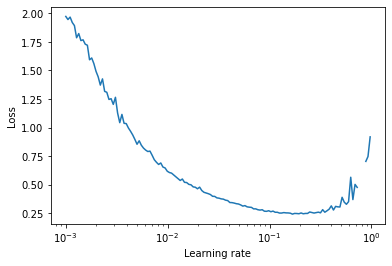

In [18]:
plt.plot(rates, losses)
plt.gca().set_xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

En este caso se ha escogido un learning rate de 0.1

In [12]:
run_logdir = os.path.join('three_layer_model',get_run_logdir())

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint("three_layer_model.h5",
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

three_layer_model = build_model(n_hidden=3, n_neurons=300, learning_rate=0.1)
three_layer_history = three_layer_model.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 2.3006 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2637 - accuracy: 0.9188 - val_loss: 0.1667 - val_accuracy: 0.9486
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1017 - accuracy: 0.9681 - val_loss: 0.0938 - val_accuracy: 0.9716
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0685 - accuracy: 0.9789 - val_loss: 0.0847 - val_accuracy: 0.9732
Epoch 4/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0509 - accuracy: 0.9836 - val_loss: 0.0795 - val_accuracy: 0.9768
Epoch 5/100
1719/1719 [==============================

In [28]:
loss_3l, accuracy_3l = three_layer_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 701us/step - loss: 0.0658 - accuracy: 0.9804


De nuevo se obtiene una exactitud de aproximadamente 98%

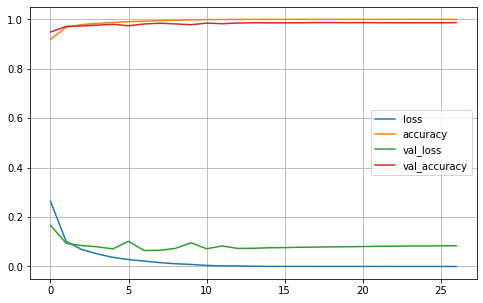

In [14]:
plot_accuracy_loss(three_layer_history)

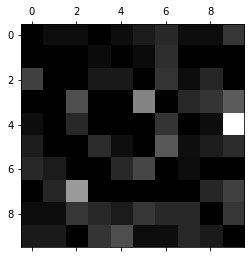

In [15]:
y_pred = three_layer_model.predict(X_test)
plot_conf_mx(y_pred)

## 4 capas ocultas

Se repite el mismo proceso para el modelo de 4 capas ocultas.

In [23]:
my_learning_rate = 1e-3
rates = []
losses = []
while my_learning_rate <= 1:
    model = build_model(n_hidden=4, n_neurons=300, learning_rate=my_learning_rate)
    history = model.fit(X_train, y_train, epochs=1,
              validation_data=(X_valid, y_valid))
    rates.append(my_learning_rate)
    losses.append(history.history['loss'][0])
    my_learning_rate = my_learning_rate*1.05    

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3762 - accuracy: 0.8867 - val_loss: 0.1495 - val_accuracy: 0.9580


1719/1719 [==============================] - 4s 2ms/step - loss: 2.3099 - accuracy: 0.1108 - val_loss: 2.3037 - val_accuracy: 0.0986


Text(0, 0.5, 'Loss')

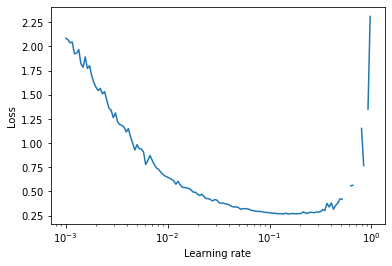

In [24]:
plt.plot(rates, losses)
plt.gca().set_xscale('log')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Se elige 0.1 para el learning rate

In [16]:
run_logdir = os.path.join('four_layer_model',get_run_logdir())

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint("four_layer_model.h5",
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

four_layer_model = build_model(n_hidden=4, n_neurons=300, learning_rate=0.1)
four_layer_history = four_layer_model.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2798 - accuracy: 0.9145 - val_loss: 0.1481 - val_accuracy: 0.9536
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1061 - accuracy: 0.9672 - val_loss: 0.0978 - val_accuracy: 0.9684
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0715 - accuracy: 0.9776 - val_loss: 0.0737 - val_accuracy: 0.9770
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 0.0832 - val_accuracy: 0.9738
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0382 - accuracy: 0.9878 - val_loss: 0.1000 - val_accuracy: 0.9740
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0305 - accuracy: 0.9901 - val_loss: 0.0748 - val_accuracy: 0.9788
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0884 - val_ac

In [29]:
loss_4l, accuracy_4l = four_layer_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 924us/step - loss: 0.0795 - accuracy: 0.9826


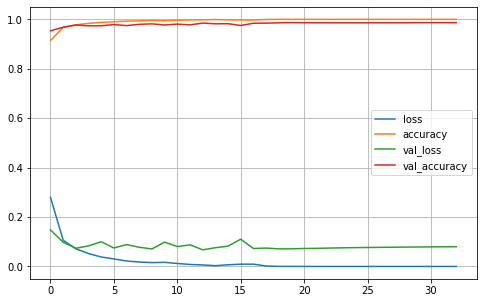

In [18]:
plot_accuracy_loss(four_layer_history)

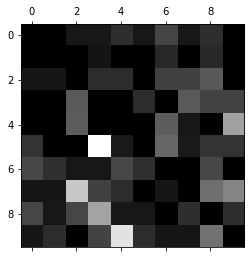

In [19]:
y_pred = four_layer_model.predict(X_test)
plot_conf_mx(y_pred)

Ahora que ya se han entrenado los tres modelos se pueden comparar sus accuracies y sus losses

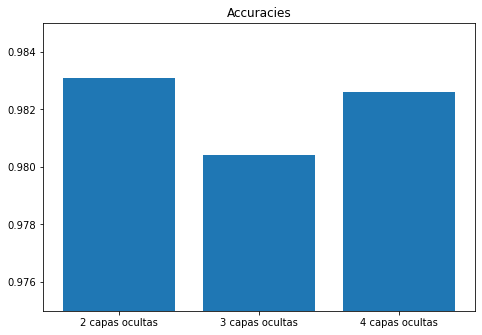

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['2 capas ocultas', '3 capas ocultas', '4 capas ocultas']
accuracies = [accuracy_2l,accuracy_3l,accuracy_4l]
ax.bar(labels,accuracies)
ax.set_ylim([0.975,0.985])
ax.set_title('Accuracies')
plt.show()

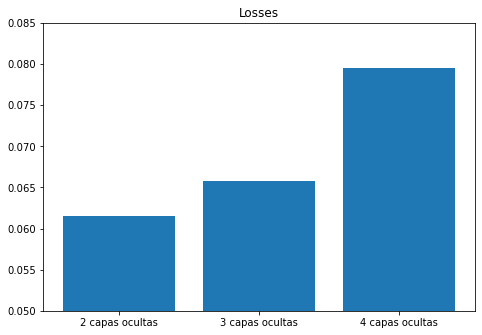

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['2 capas ocultas', '3 capas ocultas', '4 capas ocultas']
accuracies = [loss_2l,loss_3l,loss_4l]
ax.bar(labels,accuracies)
ax.set_ylim([0.05,0.085])
ax.set_title('Losses')
plt.show()

## Conclusiones

Los tres modelos alcanzan una exactitud muy similar de alrededor del 98%. Esto indica que si el modelo tiene un número suficientemente alto de parámetros (en este caso weights and biases), variar el número de capas no afecta a la calidad del modelo. 

Un hiperparámetro que si resulta crucial es el learning rate, pues como se puede ver en las curvas de loss vs learning rate, para un learning rate muy pequeño el modelo aprende muy despacio, pero para un valor demasiado alto el modelo nunca será capz de aprender.

Por otro lado, las matrices de confusión indican que hay números que el modelo tiende a clasificar mal. Entrenando varias veces cada modelo se ha observado que de manera consistente suele confundir el 3 con el 5 y el 4 con el 9. Esto es bastante lógico ya que dependiendo de como escriba una persona estos números pueden parecerse mucho.

Por último, se ha observado que el modelo de red neuronal puede producir resultados distintos cada vez que se entrena. Esto es debido a que el proceso de entrenamiento tiene una aleatoriedad inherente en la inicialización de los pesos. Aunque esto no ha supuesto un problema, conviene tenerlo en cuenta al comparar modelos con exactitudes similares, como se ha dado en este ejercicio.